# Diminos Case Study
Objective: To analyze pizza order delivery times and evaluate whether the store meets Diminos SLA requirement of keeping the 95th percentile delivery time under 31 minutes, while identifying operational improvements to reduce delays.

## 1. Import Libraries and Read the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("diminos_data.csv")
df.head()

,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [ ]:
df.isnull().sum()

,0
order_id,0
order_placed_at,0
order_delivered_at,0


In [ ]:
df.describe()

,order_id
count,1.500000e+04
mean,1.530610e+06
std,4.330271e+03
min,1.523111e+06
25%,1.526861e+06
50%,1.530610e+06
75%,1.534360e+06
max,1.538110e+06


## 2. Data Preprocessing
2.1 Convert timestamps to datetime

In [ ]:
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

2.2 Calculate Delivery Time (in minutes)

In [ ]:
df['delivery_time_mins'] = (df['order_delivered_at'] - df['order_placed_at']).dt.total_seconds() / 60

In [ ]:
df[['delivery_time_mins']].describe()

,delivery_time_mins
count,15000.000000
mean,20.499389
std,96.160362
min,15.000010
25%,15.274826
50%,15.797986
75%,17.279661
max,7299.831375


## 3. Orders delivered within & beyond SLA

In [ ]:
within_sla = (df['delivery_time_mins'] <= 31).mean() * 100
beyond_sla = 100 - within_sla

within_sla, beyond_sla

(np.float64(96.28666666666666), np.float64(3.7133333333333383))

## 4. 95th Percentile Analysis

In [ ]:
p95 = np.percentile(df['delivery_time_mins'], 95)
p95

np.float64(27.261043996666658)

In [ ]:
if p95 < 31:
    print("Store meets Diminos SLA requirement")
else:
    print("Store does not meet Diminos SLA requirement")

Store meets Diminos SLA requirement


## 5. Distribution of Delivery Time
**Orders beyond 60 minutes are extreme failures and were excluded for visualization clarity.**

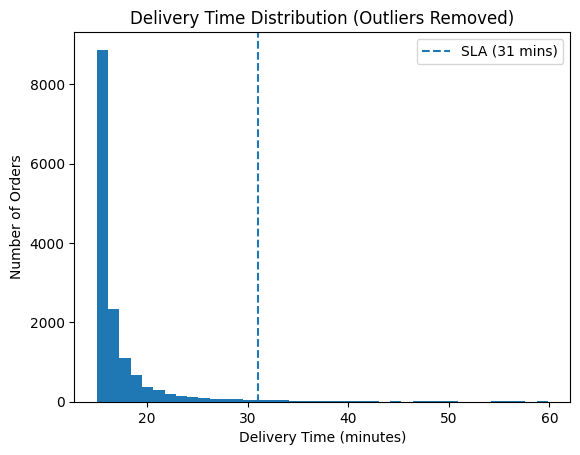

In [ ]:
filtered_df = df[df['delivery_time_mins'] <= 60]

plt.figure()
plt.hist(filtered_df['delivery_time_mins'], bins=40)
plt.axvline(31, linestyle='--', label='SLA (31 mins)')
plt.legend()
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Number of Orders")
plt.title("Delivery Time Distribution (Outliers Removed)")
plt.show()

## 6. Time-Based Analysis (Peak Hour Impact)
6.1 Extract Hour of Order

In [ ]:
df['order_hour'] = df['order_placed_at'].dt.hour

6.2 Average delivery time per hour

In [ ]:
hourly_avg = df.groupby('order_hour')['delivery_time_mins'].mean()

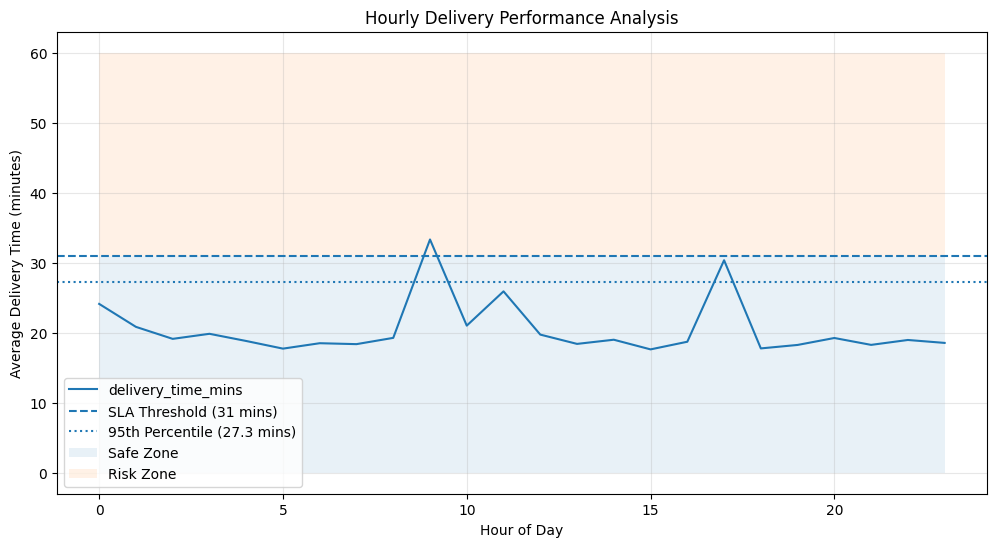

In [ ]:
plt.figure(figsize=(12, 6))
hourly_avg.plot()
plt.axhline(31, linestyle='--', label='SLA Threshold (31 mins)')
plt.axhline(p95, linestyle=':', label=f'95th Percentile ({p95:.1f} mins)')
plt.fill_between(range(24), 0, 31, alpha=0.1, label='Safe Zone')
plt.fill_between(range(24), 31, 60, alpha=0.1, label='Risk Zone')
plt.xlabel("Hour of Day")
plt.ylabel("Average Delivery Time (minutes)")
plt.title("Hourly Delivery Performance Analysis")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

6.3 Hours where average delivery time > 25 mins

In [ ]:
problem_hours = hourly_avg[hourly_avg > 25]

print("Hours requiring attention:")
print(problem_hours)

Hours requiring attention:
order_hour
9     33.320277
11    25.908233
17    30.352864
Name: delivery_time_mins, dtype: float64


## 7. Identifying Problematic Orders
7.1 Orders causing SLA failure

In [ ]:
delayed_orders = df[df['delivery_time_mins'] > 31]
delayed_orders.shape

(557, 5)

7.2 Extreme delays (Top 5%)

In [ ]:
df[df['delivery_time_mins'] > p95].head()

,order_id,order_placed_at,order_delivered_at,delivery_time_mins,order_hour
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399,38.533657,0
6,1523117,2023-03-01 00:11:09,2023-03-01 00:41:54.245295,30.754088,0
24,1523135,2023-03-01 01:11:53,2023-03-01 05:07:54.563978,236.026066,1
47,1523158,2023-03-01 01:57:16,2023-03-01 02:30:19.851911,33.064199,1
76,1523187,2023-03-01 03:05:16,2023-03-01 03:35:47.166291,30.519438,3


## Key Insights
*   Average delivery time is within acceptable limits, but average performance alone is misleading.
*   A small percentage of highly delayed orders significantly increases the 95th percentile delivery time.
*   Delivery times tend to increase during late-morning and evening hours.

## Suggestions to keep the business up and running.
*   Increase delivery staff and kitchen readiness during peak hours
*   Limit the number of orders given per delivery partner during rush hours.
*   Track the 95th percentile delivery time daily to detect risk early.


